<a href="https://colab.research.google.com/github/dtabuena/Data_Explore/blob/main/2022_12_05_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install XlsxWriter
!pip install pingouin
from IPython.display import clear_output
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

clear_output()

from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scipy
from pandas.compat.numpy import np_array_datetime64_compat
from random import sample
from tqdm import tqdm
import os
import shutil
from google import colab

clear_output()

In [92]:

def get_files(link):
    my_drop_folder = 'my_drop_folder'
    zipped_file_path = "/content/"+my_drop_folder + ".zip"
    unzipped_file_path = "/content/"+my_drop_folder
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    file_list = [f for r,d,f in os.walk("/content/"+my_drop_folder )][0]
    return file_list

def read_data_file(xl_to_analyze):
    my_df_dict  = pd.read_excel('my_drop_folder/'+xl_to_analyze, engine='openpyxl',index_col=None,sheet_name=None)
    return my_df_dict, xl_to_analyze

def dict_to_df(my_df_dict,AP_cut=60):
    '''convert dict of categories into a DF'''
    for k in my_df_dict.keys():
        df = my_df_dict[k]
        df['type'] = k
    df_list = [my_df_dict[k] for k in my_df_dict.keys()]
    full_df = pd.concat(df_list,ignore_index=True)

    '''drop low AP amps'''
    for r in full_df.index:
        if full_df.loc[r,'AP amp'] <AP_cut:
            full_df.at[r,'AP amp'] = np.nan
    return full_df

def clean_data(labeling,full_df):

    numericals = [c for c in full_df.columns if c not in labeling ]

    full_df_norm = full_df.copy()
    mean_dict = {}
    sd_dict = {}

    if 'extras' not in full_df.columns:
        exclude_extras = False
        plot_extras = False

    for c in full_df_norm.columns:
        if c not in labeling:
            col_mean = np.mean(full_df_norm[c])
            col_sd = np.std(full_df_norm[c])
            mean_dict[c] = col_mean
            sd_dict[c] = col_sd
            full_df_norm[c] = (full_df_norm[c] - col_mean)/col_sd


    null_check = pd.isna(full_df_norm)
    incomplete =[]
    for r in full_df_norm.index:
        vals = np.array(null_check.loc[r,numericals])
        bad = any(vals)
        if bad:
            incomplete.append(r)


    complete = [c for c in  full_df_norm.index if c not in incomplete]
    full_df_no_null = full_df_norm.loc[complete].copy()


    if exclude_extras:
        is_extra = list(full_df_no_null['extra']==1)
        extra_ind = full_df_no_null.index[is_extra]
        full_df_no_null.drop( index =extra_ind, inplace=True)


    data_X = full_df_no_null[numericals].to_numpy()
    data_for_fit = data_X
    numericals = [n.replace('(1)', '') for n in numericals]
    return numericals, data_for_fit, full_df_no_null

def get_types(full_df_no_null):
    type_list = list(full_df_no_null['type'])
    uniq_types = list(set(type_list))
    uniq_types.sort()
    alphanum_types = [t.replace(' 9mo', ' 09mo') for t in uniq_types]
    new_ord = list(np.array(alphanum_types).argsort())
    uniq_types = [uniq_types[i] for i in new_ord]
    # print(uniq_types)
    num_t = len(uniq_types)
    type_num = [ uniq_types.index(t) for t in type_list]
    return type_num, num_t, uniq_types,type_list

def cluster_full(data_for_fit,xl_to_analyze):
    random_state = 42
    if 'CA1' in xl_to_analyze:
        random_state = 42
    if 'Type I ' in xl_to_analyze:
        random_state = 45
    if 'Type II ' in xl_to_analyze:
        random_state = 42
    print('random_state',random_state)

    kmeans = KMeans(n_clusters=2, random_state=random_state).fit(data_for_fit)
    centers = kmeans.cluster_centers_.T
    distances = kmeans.transform(data_for_fit)
    rel_centers = (centers.T - np.mean(centers.T,axis = 0)).T


    labels = kmeans.labels_ 
    rel_counts = [np.mean( l == labels ) for l in range(2)]
    new_cent_order = np.argsort(centers[:,0]).tolist()

    total_D = np.tile(np.sum(distances,axis=1),[2,1]).T
    closeness = np.log(total_D/distances)
    closeness = (closeness - np.mean(closeness,axis=0)) / (np.std(closeness,axis=0))  
    distances_norm = (distances - np.mean(distances,axis=0)) / (np.std(distances,axis=0))
    score = closeness[:,1] - closeness[:,0]

    packaged = {'kmeans':kmeans,
                'centers':centers,
                'distances':distances,
                'rel_centers':rel_centers,
                'rel_counts':rel_counts,
                'total_D':total_D,
                'closeness':closeness,
                'distances_norm':distances_norm,
                'score':score,
                'data_for_fit':data_for_fit,
                'new_cent_order':new_cent_order
                }

    return packaged


def plot_summary(num_t,numericals,type_list,uniq_types,packaged,df_for_34_2W_anova,folder, clust_names = ['Hyperexcitable', 'Normal']):
    fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}

    kmeans = packaged['kmeans']
    centers = packaged['centers']
    distances = packaged['distances']
    rel_centers = packaged['rel_centers']
    rel_counts = packaged['rel_counts']
    total_D = packaged['total_D']
    closeness = packaged['closeness']
    distances_norm = packaged['distances_norm']
    score = packaged['score']
    data_for_fit = packaged['data_for_fit']



    plt.rcParams.update({'font.size': 18})
    colors = plt.cm.viridis(np.linspace(0,1,num_t))
    alpha_1 = .65
    alpha_2 = .05
    colors = [[0, 0, 1, alpha_1], [0, 0, 1, alpha_2],
            [1, 0, 0, alpha_1], [1, 0, 0, alpha_2], 
            [0, 0.5, 0, alpha_1], [0, 0.5, 0, alpha_2]]
    list_colors = [colors[i] for i in type_num ]


    '''### raw_data_map '''
    plt.rcParams.update({'font.size': 14})
    counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
    fig, ax = plt.subplots(1,num_t,figsize = [15,3],gridspec_kw={'width_ratios': counts})
    data_X_min = np.min(data_for_fit)
    data_X_max = np.max(data_for_fit)
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

        c = ax[ti].pcolor(data_for_fit.T[:,is_type], vmin=data_X_min, vmax=data_X_max)
        ax[ti].set_yticks(np.arange(len(numericals))+0.5)
        if ti ==0 : ax[ti].set_yticklabels(numericals,rotation=0)
        else:  ax[ti].get_yaxis().set_visible(False)
        ax[ti].set_xlabel('Cell N')
        ax[ti].title.set_text(t)

        start = min(is_type)+3 / len(is_type)
        stop = max(is_type)-3 / len(is_type)
    plt.colorbar(c, ax=ax[ti],label='z-scored values')
    plt.show()
    fig.savefig('Normalized_Vals_split.'+fig_opt['format'],**fig_opt)


    ''' Centers and Pie'''
    new_cent_order = np.argsort(centers[:,0]).tolist()
    fig_clust_pie, ax = plt.subplots(1,2,figsize = [12,5], gridspec_kw={'width_ratios': [2, 1]} )
    fig_centers, ax = plt.subplots(1,1,figsize = [8,5])
    ax.plot(rel_centers[new_cent_order,:],'-o')
    ax.legend(clust_names,loc='lower center',fontsize=10)
    sorted_numericals = [numericals[i] for i in new_cent_order]
    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor',fontsize=14)
    ax.set_ylabel('z-scored values') 
    ax.axhline(0,color='k')
    ax.title.set_text('Cluster Centers')
    plt.tight_layout()

    fig_pie,ax = plt.subplots(1,1,figsize = [4,5])
    ax.pie( rel_counts, labels=clust_names,autopct='%1.1f%%' )
    plt.tight_layout()

    ################# Distance heat map
    fig_distances, ax = plt.subplots(1,figsize = [15,3])
    c = ax.pcolor(distances_norm.T)
    ax.set_xlabel('Cell')
    ax.set_yticks(np.arange(2)+0.5)
    ax.set_yticklabels(clust_names)
    fig_distances.colorbar(c, ax=ax,label='z-scored distance')
    fig_distances.savefig('Cells_in_Clusters.'+fig_opt['format'],**fig_opt)

    ############# Combined Scatter
    fig_comb_scatter, ax = plt.subplots(1,figsize = [12,12])
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]    
        t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        ax.scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=80)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Dist. from '+clust_names[0]+' Center \n (z-scored)')
    ax.set_ylabel('Dist. from '+clust_names[1]+' Center \n (z-scored)')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k')
    ax.text(0.98, 0.02, 'Strong '+clust_names[1],transform=ax.transAxes,ha='right',va='bottom',fontsize=28)
    ax.text(0.02, 0.98, 'Strong '+clust_names[0],transform=ax.transAxes,ha='left',va='top',fontsize=28)

    comb_xlim = ax.get_xlim()
    comb_ylim = ax.get_ylim()

    #### separate Scatter #####
    fig_sep_scatter, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*5,10])
    axs = axs.T.flatten()
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
        axs[ti].scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=50)
        # axs[ti].set_xlabel('Dist. From Type_1')
        # axs[ti].set_ylabel('Dist. From Type_2')
        axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes,color=[0,0,0,1])
        axs[ti].title.set_text(t)
        axs[ti].set_xlim(comb_xlim)
        axs[ti].set_ylim(comb_ylim)


        axs[ti].set_xlabel(clust_names[0]+' Dist.',fontsize=12)
        axs[ti].set_ylabel(clust_names[1]+' Dist.',fontsize=12)
        axs[ti].text(0.98, 0.02, 'Strong \n'+clust_names[1],transform=axs[ti].transAxes,ha='right',va='bottom',fontsize=12)
        axs[ti].text(0.02, 0.98, 'Strong \n'+clust_names[0],transform=axs[ti].transAxes,ha='left',va='top',fontsize=12)


    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


    #### separate PDFS #####
    fig_sep_hist, axs = plt.subplots(2,int(num_t/2),figsize = [int(num_t/2)*5,5])
    axs = axs.T.flatten()
    for ti in range(num_t):
        t = uniq_types[ti]
        t_colr = colors[ti]
        t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
        is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

        axs[ti].hist(score[is_type],14,color=t_colr,histtype='bar',density=True,range=(-3.25,3.25),edgecolor=t_colr_edge,linewidth=1)
        axs[ti].title.set_text(t)
        axs[ti].axvline(0, color='k') # vertical
        axs[ti].set_ylim(0,0.65)
        axs[ti].set_ylabel('PDF')
        fs = 14
        axs[ti].text(.95, .85, clust_names[1],transform=axs[ti].transAxes,ha='right',fontsize = fs)
        axs[ti].text(.05, .85, clust_names[0],transform=axs[ti].transAxes,ha='left',fontsize = fs)

    axs[3].set_xlabel('Residuals')
    plt.tight_layout()



    ''' Bars of Residuals '''
    fig_res_bars, ax = plt.subplots(1,figsize=[4,5])
    comb_list = list(set(df_for_34_2W_anova['combination']))

    alphanum_comb_list = [t.replace(' 9mo', ' 09mo') for t in comb_list]
    new_ord = list(np.array(alphanum_comb_list).argsort())
    comb_list = [comb_list[i] for i in new_ord]
    
    sns_dict={}
    for ti in range(len(comb_list)):
        type_i = comb_list[ti]
        match_type = df_for_34_2W_anova['combination']==type_i
        y_vals = list(np.array(df_for_34_2W_anova[match_type]['T1_Score']))
        x_vals = np.ones_like(y_vals)*ti
        pos = list(np.ones_like(y_vals)*ti)
        t_colr = colors[ti]    
        t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
        # sns_dict[type_i] = y_vals
        sns_dict[type_i] =y_vals

    colors_sns = colors
    colors_sns = [ [colors_sns[(i)*2+1], colors_sns[(i)*2]] for i in range(int(len(colors_sns)/2))]
    colors_sns = sum(colors_sns, [])
    colors_sns = [np.array(c) for c in colors_sns]
    colors_sns = [ list(c+(1-c)*c[3])   for c in colors_sns]
    print(colors_sns)
    sns_df =  pd.DataFrame.from_dict(sns_dict, orient='index').T
    sns.swarmplot(ax=ax,data=sns_df,palette=colors_sns, label=t,linewidths=1,edgecolors='k',size=8)
        # print('ti',ti,x_vals)
        # ax.scatter(np.ones_like(y_vals)*ti,y_vals,  color=t_colr, label=t,linewidths=1,edgecolors='k',s=30, zorder=5)
        # mean = np.mean(y_vals)
        # sem = scipy.stats.sem(y_vals)
        # error_kw = {'elinewidth':3,'capthick':3,'ecolor':t_colr_edge}
        # ax.bar(ti,mean,yerr=sem,color=t_colr, edgecolor=t_colr_edge,capsize=10,linewidth=3,error_kw=error_kw)

    ax.text(.05, .95, clust_names[1],transform=ax.transAxes,ha='left',fontsize = fs)
    ax.text(.05, .02, clust_names[0],transform=ax.transAxes,ha='left',fontsize = fs)
    ax.set_ylabel('Residual Value')
    ax.set_ylim(-5,5)
    ax.axhline(0,color='k')
    # ax.set_xticks(ticks=range(len(comb_list)))
    ax.set_xticklabels(comb_list,rotation=45,ha='right', rotation_mode='anchor')
    plt.show()

    fig_res_bars.savefig(f'{folder}/Summary_Bars.'+fig_opt['format'],**fig_opt)    
    fig_centers.savefig(f'{folder}/centers.'+fig_opt['format'],**fig_opt)
    fig_pie.savefig(f'{folder}/pie.'+fig_opt['format'],**fig_opt)
    fig_sep_scatter.savefig(f'{folder}/GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)
    fig_comb_scatter.savefig(f'{folder}/GenoType_dist.'+fig_opt['format'],**fig_opt)
    fig_sep_hist.savefig(f'{folder}/GenoType_Histos.'+fig_opt['format'],**fig_opt)
    return None    


def do_stats(type_list,score):
    is_E3 = ['E3' in t for t in type_list ]
    is_9mo = [' 19' not in t for t in type_list ]
    age_list = [9 if b else 19 for b in is_9mo]
    genotype = ['E3' if b else 'E4' for b in is_E3]
    is_crePos = ['cre+' in t for t in type_list ]
    is_creNeg = ['cre-' in t for t in type_list ]
    not_cree = [not any( [is_crePos[i], is_creNeg[i]] ) for i in range(len(is_crePos))]
    e34_genotype = [genotype[i] for i in range(len(not_cree)) if not_cree[i]]
    e34_score = [score[i] for i in range(len(not_cree)) if not_cree[i]]
    e34_age = [str(age_list[i])+'mo' for i in range(len(not_cree)) if not_cree[i]]
    genotype_list_str = [t.replace(' 9mo', '').replace(' 19mo', '') for t in type_list]
    age_list_str = [str(a)+'mo' for a in age_list]
    # age_list_str = [a if '19' in a else ' '+a for a in age_list_str ] # spacer
    df_for_34_2W_anova =  pd.DataFrame({'genotype': genotype_list_str,  'Age': age_list_str,'T1_Score': score})


    ANOVA2_results = pg.anova(dv='T1_Score', between=['genotype', 'Age'], data=df_for_34_2W_anova, detailed=True)
    display(ANOVA2_results)

    ANOVA2_results.to_csv(f'{folder}/2W_results Age-Geno.csv')
    df_for_34_2W_anova['combination'] = df_for_34_2W_anova.genotype + " " + df_for_34_2W_anova.Age
    m_comp = pairwise_tukeyhsd(endog=df_for_34_2W_anova['T1_Score'], groups=df_for_34_2W_anova['combination'], alpha=0.05)
    tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
    tukey_data = tukey_data.sort_values('p-adj',ascending=True)
    display(tukey_data)

    tukey_data.to_csv(f'{folder}/pairwise Age-Genotype.csv')
    df_for_34_2W_anova.to_csv(f'{folder}/Scores.csv')
    return df_for_34_2W_anova




def cross_val(data_for_fit,new_cent_order,folder,k=2,num_iter = 1000,SubSampleFrac = .8):
    fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}
    center_list = []
    label_list = []
    sub_sample_ind_list = []
    full_label_list = []
    pred_all = True
    sorted_numericals = [numericals[i] for i in new_cent_order]

    for ni in tqdm( range(num_iter) ):
        sub_sample_ind = []
        for t in uniq_types:
            t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
            # print(t_inds)
            sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
        kmeans_iter = KMeans(n_clusters=k, random_state=42).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
        centers_iter = kmeans_iter.cluster_centers_.T
        centers_iter = centers_iter - np.mean(centers_iter,axis=0)
        labels_iter = kmeans_iter.labels_
        if pred_all:
            labels_iter = kmeans_iter.predict(data_for_fit)

        if ni>0:
            corco = np.corrcoef(centers_iter.T,center_list[0].T)
            corco = corco[0:k,k:]
            ind = np.argmax(corco,axis=0) 
            centers_iter = centers_iter[:,ind]
            labels_iter = [ind[l] for l in labels_iter]
        
        if not pred_all:
            full_label_iter = np.empty((data_for_fit.shape[0],))
            full_label_iter[:] = np.nan
            full_label_iter[sub_sample_ind] = labels_iter
        else:
            full_label_iter = labels_iter

        center_list.append(centers_iter)
        label_list.append(labels_iter)
        sub_sample_ind_list.append(sub_sample_ind_list)
        full_label_list.append(full_label_iter)
   
    center_stack = np.stack(center_list)
    mean_center = np.mean(center_stack,0)
    nintey_p_center = np.percentile(center_stack, [.5, 99.5], axis=0)

    cmap = plt.cm.viridis(np.linspace(0,1,k))
    fig_cv_cent, ax = plt.subplots(1,figsize = (10,5))
    for ki in range(k):
        ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki])
        ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki])
        ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki])

    ax.set_xticks(np.arange(len(numericals)))
    ax.set_xticklabels(sorted_numericals,rotation=45,ha='right', rotation_mode='anchor',fontsize=14)
    ax.axhline(0, color='k')



    full_label_stack = np.stack(full_label_list)

    pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
    is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
    is_match[np.isnan(full_label_stack)]=np.nan
    consistency_iter = np.nanmean(is_match, axis = 1)
    mean_consistency_iter = np.nanmean(consistency_iter)
    std_consistency_iter = np.nanstd(consistency_iter)
    consistency_cell = np.nanmean(is_match, axis = 0)
    mean_consistency_cell = np.nanmean(consistency_cell)
    sd_consistency_cell = np.nanstd(consistency_cell)
    consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
    # print(consistency_report)
    # print('(chance: ' + str(round(1/k*100,1))+')')
    ax.title.set_text(f'{num_iter} iterations\n(80:20 train:test)' )

    # plt.rcParams.update({'font.size': 18})
    plt.tight_layout()
    plt.show()
    fig_cv_cent.savefig(f'{folder}/CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

    fig_cv_prob, ax = plt.subplots(2,2,figsize=[8,6], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
    ax  = ax.T.flatten()
    ax[0].pcolor( full_label_stack )
    ax[0].set_xlabel('Cell')
    ax[0].set_ylabel('Iteration')
    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top()

    ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
    ax[1].axhline(1/k*100,color='k',linestyle=':')
    ax[1].set_ylabel('Cell Consistency (%)')
    ax[1].set_ylim((0,102))
    ax[1].set_xlim((0,is_match.shape[1]))
    ax[1].set_xlabel('Cell')


    ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
    ax[2].axvline(1/k*100,color='k',linestyle=':')
    ax[2].set_xlabel('Iter Consistency (%)')
    ax[2].set_xlim((102,0))
    ax[2].set_ylim((0,num_iter))
    ax[2].yaxis.tick_right()
    ax[2].xaxis.set_label_position('top') 
    ax[2].xaxis.tick_top()

    # fig.delaxes(ax[3])
    ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100, yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
    ax[3].axvline(1/k*100,color='k',linestyle=':')
    ax[3].axhline(1/k*100,color='k',linestyle=':')
    ax[3].set_xlim((100,0))
    ax[3].set_ylim((0,100))
    ax[3].yaxis.tick_right()

    fig_cv_prob.savefig(f'{folder}/CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)
    return None


def save_dl(folder):
    root_list = []
    f_list = []
 
    fold_name = folder
    fold_name = fold_name.replace(' ','_')
    zip_name= fold_name+'.zip'

    print(folder)
    !zip -r $zip_name $folder
    colab.files.download(zip_name)
    return None








In [3]:
link = 'https://www.dropbox.com/sh/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba?dl=0'
file_list = get_files(link)
file_list = [f for f in file_list if 'param' in f]
print(file_list)


--2022-12-06 17:33:35--  https://www.dropbox.com/sh/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba [following]
--2022-12-06 17:33:36--  https://www.dropbox.com/sh/raw/vnndh8qo9dkhyh3/AABc-bU5bXepR5PmBcQMvwrba
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6669a8eab17b5dc96b28a88654.dl.dropboxusercontent.com/zip_download_get/BViPl_clsUE8LRrTQC7VmsugkVCXkyUtcorugV51_Mmx_hLM1gSEEgqpZKBsvRvDc9Pb4w-bBJA3j0xNSrERMkl9ocwpdKJa2lsZcvTCT-ofoQ# [following]
--2022-12-06 17:33:37--  https://uc6669a8eab17b5dc96b28a88654.dl.dropboxusercontent.com/zip_download_get/BViPl_clsUE8LRrTQC7VmsugkVCXkyUtcorugV51_Mmx_hLM1gSEEgqpZKBsvRvDc9Pb4w-bBJA3j0xNSrERMkl9oc

random_state 42


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,genotype,55.629913,3.0,18.543304,5.617748,0.004571,0.114762
1,Age,16.421384,1.0,16.421384,4.974906,0.027432,0.036858
2,genotype * Age,62.095434,3.0,20.698478,6.270664,0.000523,0.126414
3,Residual,429.109586,130.0,3.300843,NaN,NaN,NaN


,group1,group2,meandiff,p-adj,lower,upper,reject
6,E3 CA3 9mo,E4 CA3 9mo,-1.8831,0.0020,-3.2766,-0.4896,True
0,E3 CA3 19mo,E3 CA3 9mo,1.8992,0.0044,0.4099,3.3885,True
5,E3 CA3 9mo,E4 CA3 19mo,-1.8196,0.0061,-3.2867,-0.3526,True
12,E4 CA3 9mo,fE4 syncre+ CA3 9mo,2.0004,0.0067,0.3758,3.6250,True
3,E3 CA3 19mo,fE4 syncre+ CA3 9mo,2.0165,0.0108,0.3090,3.7239,True
10,E4 CA3 19mo,fE4 syncre+ CA3 9mo,1.9369,0.0146,0.2488,3.6251,True
8,E3 CA3 9mo,fE4 syncre- CA3 9mo,-1.5372,0.0442,-3.0507,-0.0237,True
14,fE4 syncre+ CA3 9mo,fE4 syncre- CA3 9mo,-1.6545,0.0691,-3.3831,0.0741,False
13,E4 CA3 9mo,fE4 syncre- CA3 9mo,0.3459,0.9890,-1.2537,1.9454,False
4,E3 CA3 19mo,fE4 syncre- CA3 9mo,0.3619,0.9892,-1.3217,2.0456,False


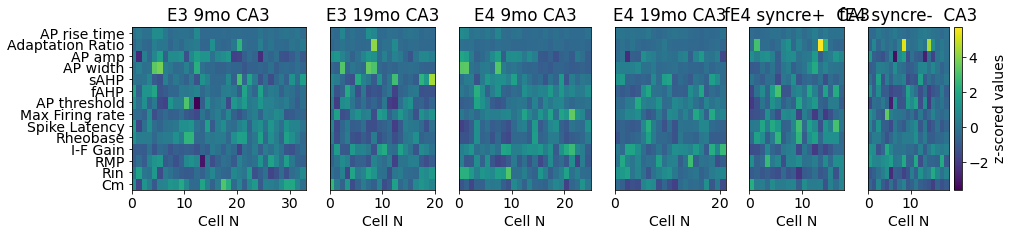

[[0.05, 0.05, 1.0, 0.0975], [0.65, 0.65, 1.0, 0.8775], [1.0, 0.05, 0.05, 0.0975], [1.0, 0.65, 0.65, 0.8775], [0.05, 0.525, 0.05, 0.0975], [0.65, 0.825, 0.65, 0.8775]]


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


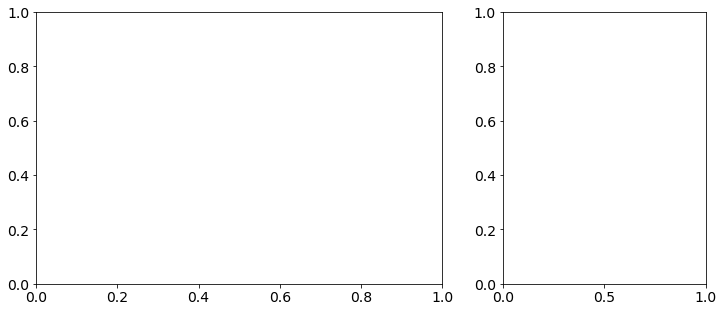

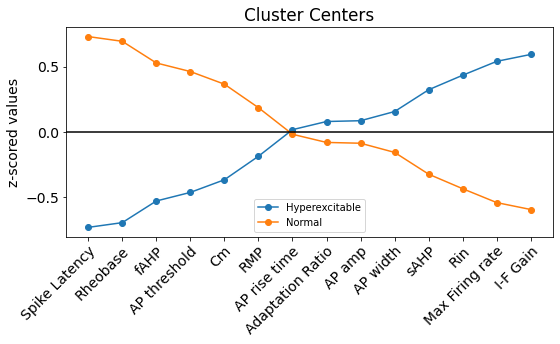

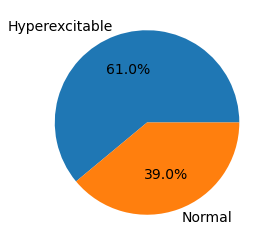

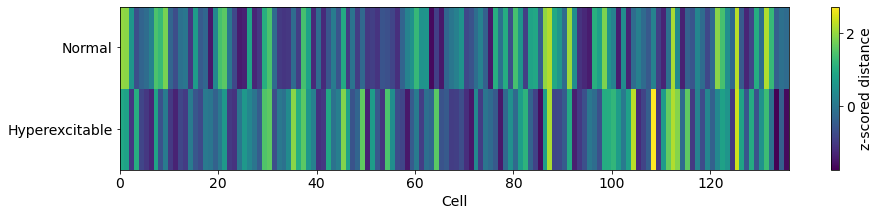

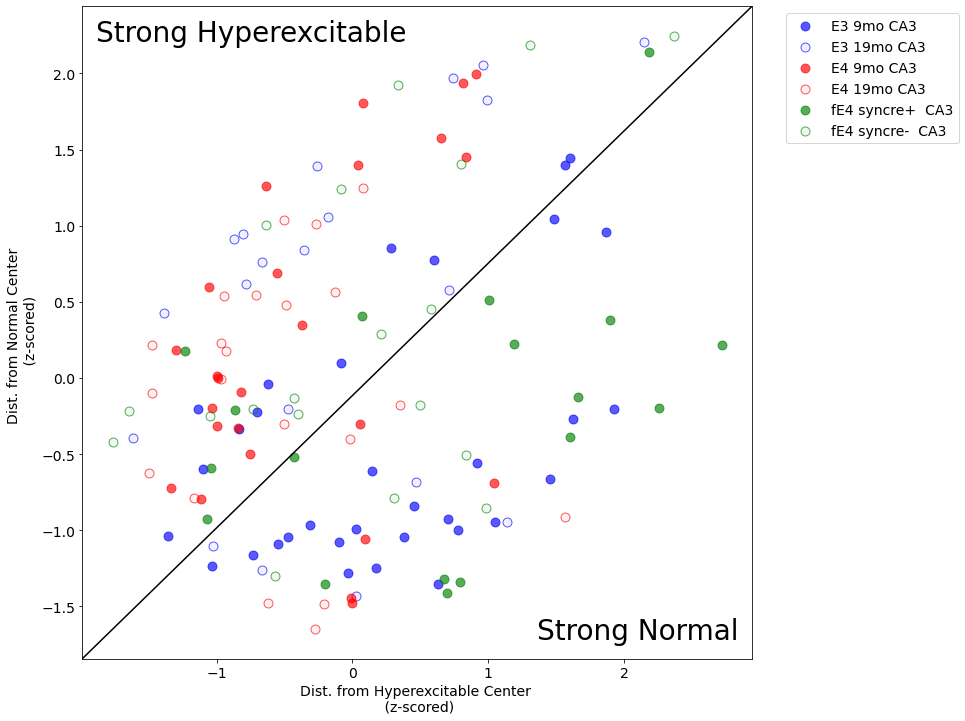

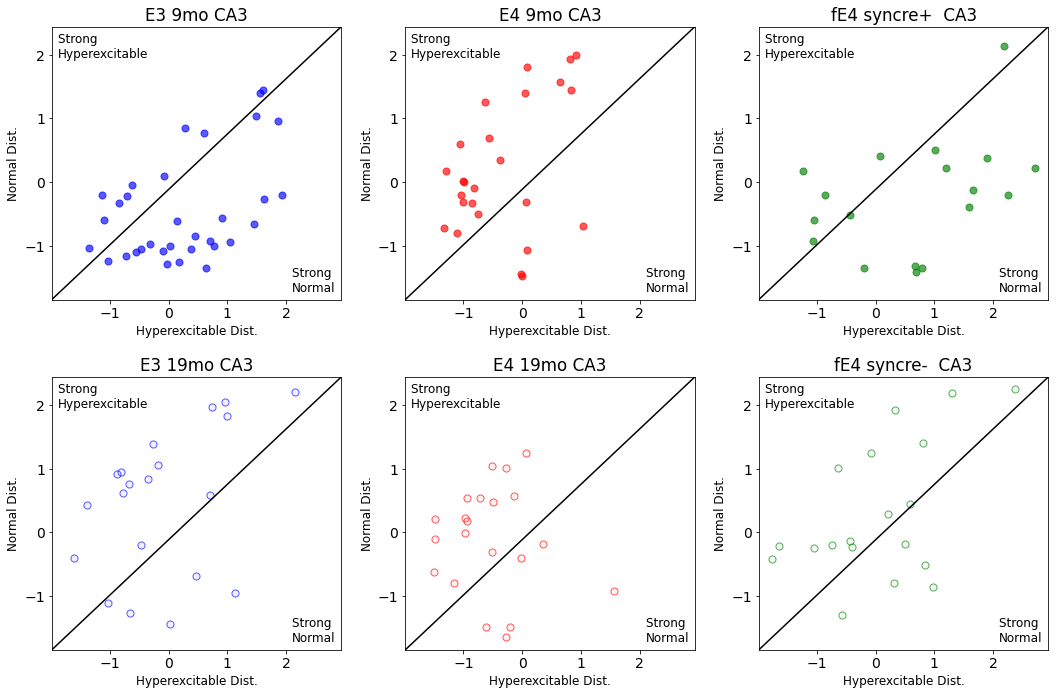

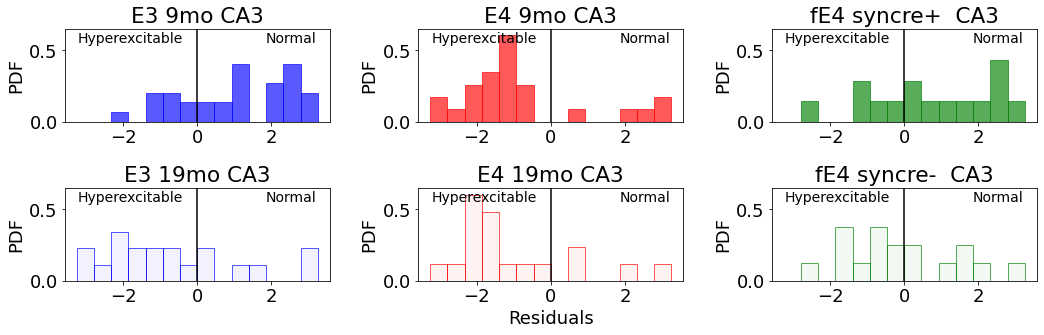

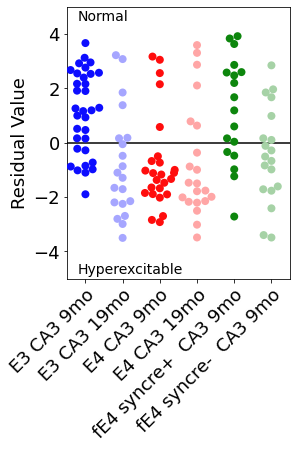

100%|██████████| 1000/1000 [00:27<00:00, 36.86it/s]


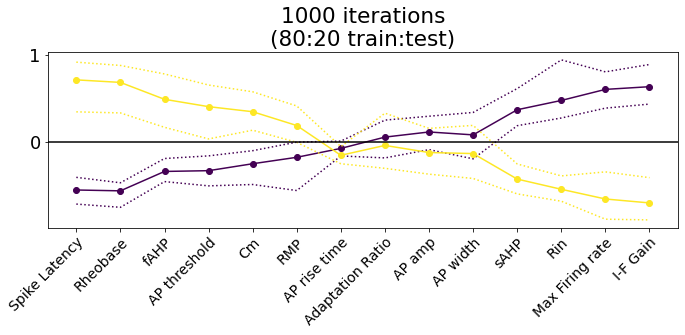

100%|██████████| 1000/1000 [00:32<00:00, 30.43it/s]


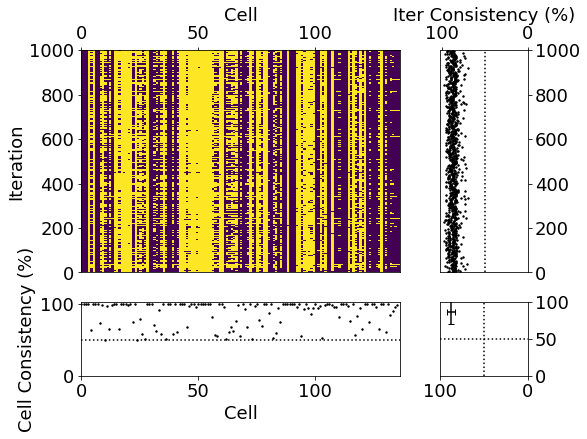

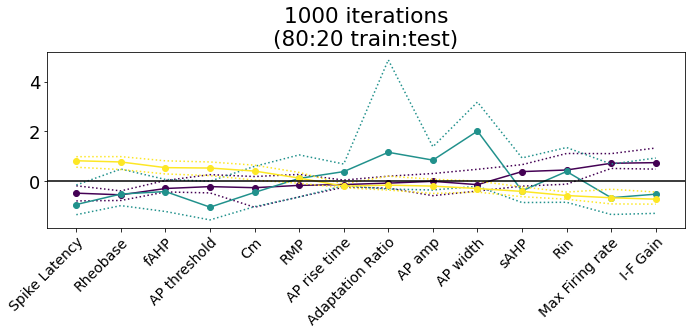

CA3_parameters_for_PCA
  adding: CA3_parameters_for_PCA/ (stored 0%)
  adding: CA3_parameters_for_PCA/Scores.csv (deflated 71%)
  adding: CA3_parameters_for_PCA/CrossVal_Data k=3 Labeling.png (deflated 8%)
  adding: CA3_parameters_for_PCA/Summary_Bars.png (deflated 6%)
  adding: CA3_parameters_for_PCA/GenoType_Histos.png (deflated 20%)
  adding: CA3_parameters_for_PCA/GenoType_dist_Separate.png (deflated 15%)
  adding: CA3_parameters_for_PCA/CrossVal_Data k=2 Centers.png (deflated 9%)
  adding: CA3_parameters_for_PCA/CrossVal_Data k=3 Centers.png (deflated 8%)
  adding: CA3_parameters_for_PCA/CrossVal_Data k=2 Labeling.png (deflated 11%)
  adding: CA3_parameters_for_PCA/GenoType_dist.png (deflated 12%)
  adding: CA3_parameters_for_PCA/2W_results Age-Geno.csv (deflated 39%)
  adding: CA3_parameters_for_PCA/pie.png (deflated 9%)
  adding: CA3_parameters_for_PCA/pairwise Age-Genotype.csv (deflated 63%)
  adding: CA3_parameters_for_PCA/centers.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TypeError: ignored

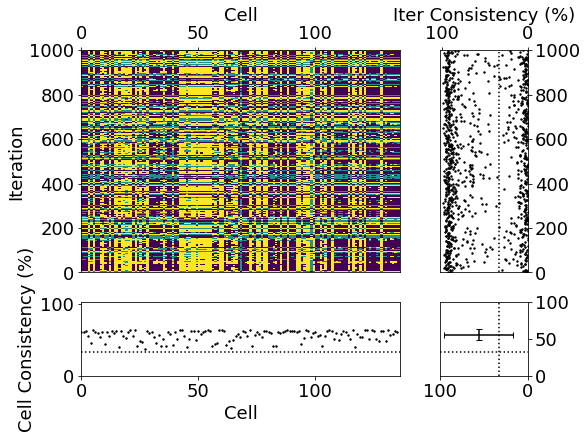

In [95]:
for f in file_list:
    my_df_dict, xl_to_analyze = read_data_file(f)
    folder = xl_to_analyze.split('.')[0].replace(' ','_')
    try: os.makedirs(folder)
    except: None
    full_df = dict_to_df(my_df_dict,AP_cut=60)
    labeling = ['cell','Cell','type','extra']
    numericals, data_for_fit, full_df_no_null = clean_data(labeling, full_df)
    type_num, num_t, uniq_types,type_list = get_types(full_df_no_null)
    packaged = cluster_full(data_for_fit,xl_to_analyze)
    df_for_34_2W_anova = do_stats(type_list,packaged['score'])
    plot_summary(num_t,numericals,type_list,uniq_types,packaged,df_for_34_2W_anova,folder)
    cross_val(data_for_fit,packaged['new_cent_order'],folder,k=2,num_iter = 1000,SubSampleFrac = .8)
    cross_val(data_for_fit,packaged['new_cent_order'],folder,k=3,num_iter = 1000,SubSampleFrac = .8)
    save_dl(folder)

In [93]:
a = [i for i in range(6)]
print(a)

b = [[a[i*2+1],a[(i*2)]]  for i in range(int(len(a)/2))]
print(b)

[0, 1, 2, 3, 4, 5]
[[1, 0], [3, 2], [5, 4]]
